In [1]:
#default_exp data_loading

In [2]:
# export
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection
import tqdm
import PIL
import numpy as np

In [3]:
%matplotlib inline
%cd ..

/home/kuba/Projects/deeplearning_image_classification


In [4]:
# export
def map_class_to_taxon(mapping, class_id, taxon='Family'):
    return mapping.loc[class_id][taxon]


def parse_image(filename, image_size=224):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [image_size, image_size])
    return image

In [5]:
# export
DATA_DIR = os.path.join('data')

In [6]:
#export
def get_metadata(data_dir=DATA_DIR):
    metadata_path = os.path.join(data_dir, 'PlantCLEF2019MasterTraining.csv')
    return pd.read_csv(metadata_path, sep=';')

In [8]:
metadata_df = get_metadata()

In [9]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434251 entries, 0 to 434250
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   MediaId      434251 non-null  object
 1   YearInCLEF   434251 non-null  object
 2   LearnTag     434251 non-null  object
 3   ClassId      434251 non-null  int64 
 4   Species      434251 non-null  object
 5   Genus        434251 non-null  object
 6   Family       434251 non-null  object
 7   Origin       434251 non-null  object
 8   OriginalUrl  434251 non-null  object
 9   BackupLink   434251 non-null  object
dtypes: int64(1), object(9)
memory usage: 33.1+ MB


In [10]:
metadata_df.head()

,MediaId,YearInCLEF,LearnTag,ClassId,Species,Genus,Family,Origin,OriginalUrl,BackupLink
0,5c3e30f1706244e9f199d5a0c5a5ec00d1cbf473,PlantCLEF2019,Train,183350,Taralea oppositifolia Aubl.,Taralea,Leguminosae,microsoftimage,http://www.bing.com/cr?IG=E56D8ED3E44B4D6BB7E1...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/183350/5...
1,83cead55f3be63d6fbe0c1e6c87ee2223c7a6e9b,PlantCLEF2019,Train,12254,Anacardium occidentale L.,Anacardium,Anacardiaceae,microsoftimage,http://www.bing.com/cr?IG=8DC6223C2EBC42F0A017...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/12254/83...
2,1e2f13d4773a8feafb68930117d1773ba712aa79,PlantCLEF2019,Train,263952,Ischaemum muticum L.,Ischaemum,Poaceae,microsoftimage,http://www.bing.com/cr?IG=DDA2A184733547F09081...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/263952/1...
3,5e49ad7196984b90ad1c5f8648fe77803b40a75b,PlantCLEF2019,Train,158247,Mezilaurus decurrens (Ducke) Kosterm.,Mezilaurus,Lauraceae,googleimage,https://encrypted-tbn0.gstatic.com/images?q=tb...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/158247/5...
4,109240430bfcca5a7c3eec0fc6a165ad242e7d55,PlantCLEF2019,Train,24496,Tabernaemontana grandiflora Jacq.,Tabernaemontana,Apocynaceae,microsoftimage,https://www.bing.com/cr?IG=836545099C7F450589B...,http://otmedia.lirmm.fr/LifeCLEF/b/gu/24496/10...


In [11]:
family_counts = metadata_df['Family'].value_counts()
family_counts[family_counts > 1000].sum()

388594

In [12]:
metadata_df['Family'].value_counts()

Orchidaceae         37703
Leguminosae         30122
Poaceae             26335
Rubiaceae           16441
Malvaceae           14765
                    ...  
Martyniaceae            7
Canellaceae             7
Anisophylleaceae        7
Metaxyaceae             2
Ranunculaceae           1
Name: Family, Length: 248, dtype: int64

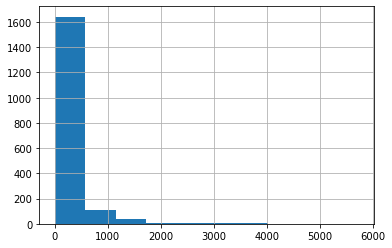

In [13]:
metadata_df['Genus'].value_counts().hist()

In [14]:
metadata_df['ClassId'].unique().shape

(10000,)

In [15]:
metadata_df['Species'].value_counts()[-2000:]

Eugenia latifolia Aubl.                    6
Besleria insolita C.V.Morton               6
Floscopa elegans Huber                     6
Eschweilera carinata S.A.Mori              6
Gunnera tayrona L.E.Mora                   6
                                          ..
Everardia debilis T.Koyama & Maguire       1
Hebepetalum neblinae Jardim & P.E.Berry    1
Pourouma ferruginea Standl.                1
Schlegelia paraensis Ducke                 1
Pouteria oblanceolata Pires                1
Name: Species, Length: 2000, dtype: int64

In [16]:
!ls data/images/data/101969

ls: cannot access 'data/images/data/101969': No such file or directory


In [17]:
# export
train_dir = os.path.join(DATA_DIR, 'images_train/data')

In [21]:
# export


def filter_invalid_images(raw_maybe_invalid_classification_metadata_df):
    failed_paths = []
    for p in tqdm.tqdm(raw_maybe_invalid_classification_metadata_df['filename']):
        try:
            img = PIL.Image.open(p)
            if len(np.asarray(img).shape) < 3:
                failed_paths.append(p)
        except:
            failed_paths.append(p)   
    return raw_maybe_invalid_classification_metadata_df[~raw_maybe_invalid_classification_metadata_df['filename'].isin(failed_paths)]


def prepare_classification_metadata(metadata_df, target_col, basepath):
    def make_filename_from_parts(parts):
        return os.path.join(*(basepath, *map(str, parts))) + '.jpg'
    filename = 'MediaId'
    df = pd.DataFrame({'class': metadata_df[target_col], 'name': metadata_df[filename]})
    df['filename'] = metadata_df[['ClassId', filename]].agg(make_filename_from_parts, axis=1)
    class_counts = metadata_df['class'].value_counts()
    return filter_invalid_images(df)


def filter_small_classes(metadata_df, min_class_examples=1000):
    class_counts = metadata_df['class'].value_counts()
    large_classes = class_counts[class_counts > 1000].index
    return metadata_df[metadata_df['class'].isin(large_classes)]

In [25]:
metadata_df['class'] = metadata_df['Family']

In [26]:
%%time

raw_classification_metadata_df = prepare_classification_metadata(metadata_df, 'Family', train_dir)

100%|██████████| 434251/434251 [46:56<00:00, 154.19it/s] 


CPU times: user 43min 55s, sys: 57.2 s, total: 44min 52s
Wall time: 47min 29s


## Number of classes

In [27]:
raw_classification_metadata_df.shape

(422043, 3)

In [28]:
classification_metadata_df = filter_small_classes(metadata_df)

In [29]:
classification_metadata_df.shape

(388594, 11)

In [ ]:
train_classification_metadata_df, test_classification_metadata_df = model_selection.train_test_split(classification_metadata_df, test_size=10000, random_state=0)

In [ ]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)

sample_image_iterator = image_gen.flow_from_dataframe(train_classification_metadata_df, target_size=(224, 224))

n_classes = len(sample_image_iterator.class_indices)

In [ ]:
batch = next(sample_image_iterator)

# Data quality

As we see from samples, images of plants have very different modalities: some of them are photos of actual plants, whereas some only contain leaves or flowers.

In [ ]:
for i in range(batch[0].shape[0]):
    plt.imshow(batch[0][i]);
    plt.show()

### This part will be used in script mode

In [ ]:
#export
train_csv_path = os.path.join(DATA_DIR, 'train_metadata.csv')
test_csv_path = os.path.join(DATA_DIR, 'test_metadata.csv')
test_size = 10000
target_class = 'Family'


if __name__ == '__main__':
    if os.path.exists(train_csv_path) or os.path.exists(test_csv_path):
        raise ValueError("some metadata file already exists, exiting")
    else:
        metadata_df = get_metadata()
        raw_classification_metadata_df = prepare_classification_metadata(metadata_df, 'Family', train_dir)
        classification_metadata_df = filter_small_classes(raw_classification_metadata_df)
        train_classification_metadata_df, test_classification_metadata_df = model_selection.train_test_split(classification_metadata_df, test_size=test_size, random_state=0)
        train_classification_metadata_df.to_csv(train_csv_path)
        test_classification_metadata_df.to_csv(test_csv_path)